<a href="https://colab.research.google.com/github/dklpp/tf-developer/blob/main/C2_W3_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

# Copy pretrained weights for the Inception Neural Network

In [2]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-11-06 12:05:28--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 173.194.79.207, 108.177.96.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  28.6MB/s    in 2.9s    

2023-11-06 12:05:31 (28.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False, # ignore FC layers at the top of InceptionV3, go straight to ConvLayers
                                weights = None) # don't use built-in weights, but the just downloaded snapshot

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [4]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

- This is because the original last layer might be too specialized in what it has learned so it might not translate well into your application. mixed7 on the other hand will be more generalized and you can start with that for your application.

In [5]:
# Choose `mixed7` as the last layer of your base model

last_layer = pre_trained_model.get_layer('mixed7') # (None, 7, 7, 768)  , after it we have (None, 3, 3, ?)
# (7, 7) has more info than (3, 3)
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [6]:
last_output

<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

In [7]:
pre_trained_model.input

<KerasTensor: shape=(None, 150, 150, 3) dtype=float32 (created by layer 'input_1')>

# Define new baseline model

In [16]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x) # Model(input, output)

model.compile(optimizer=RMSprop(learning_rate=0.0001), # learning_rate=1e-4
              loss='binary_crossentropy',
              metrics=['acc'])

# Prepare the dataset

In [9]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-11-06 12:05:48--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 173.194.79.207, 108.177.96.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  27.4MB/s    in 2.4s    

2023-11-06 12:05:50 (27.4 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [10]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Train the Model

In [18]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 50,
            validation_steps = 50,
            verbose = 2)

Epoch 1/50
100/100 - 17s - loss: 0.1166 - acc: 0.9565 - val_loss: 0.1094 - val_acc: 0.9590 - 17s/epoch - 167ms/step
Epoch 2/50
100/100 - 16s - loss: 0.1117 - acc: 0.9550 - val_loss: 0.0843 - val_acc: 0.9700 - 16s/epoch - 165ms/step
Epoch 3/50
100/100 - 18s - loss: 0.1150 - acc: 0.9585 - val_loss: 0.0847 - val_acc: 0.9680 - 18s/epoch - 178ms/step
Epoch 4/50
100/100 - 17s - loss: 0.1142 - acc: 0.9550 - val_loss: 0.1110 - val_acc: 0.9630 - 17s/epoch - 170ms/step
Epoch 5/50
100/100 - 18s - loss: 0.1178 - acc: 0.9530 - val_loss: 0.0785 - val_acc: 0.9720 - 18s/epoch - 183ms/step
Epoch 6/50
100/100 - 17s - loss: 0.1037 - acc: 0.9605 - val_loss: 0.0801 - val_acc: 0.9710 - 17s/epoch - 170ms/step
Epoch 7/50
100/100 - 17s - loss: 0.1011 - acc: 0.9610 - val_loss: 0.0921 - val_acc: 0.9690 - 17s/epoch - 174ms/step
Epoch 8/50
100/100 - 17s - loss: 0.1009 - acc: 0.9605 - val_loss: 0.0875 - val_acc: 0.9730 - 17s/epoch - 169ms/step
Epoch 9/50
100/100 - 17s - loss: 0.0965 - acc: 0.9625 - val_loss: 0.0923

# Evaluate the Results

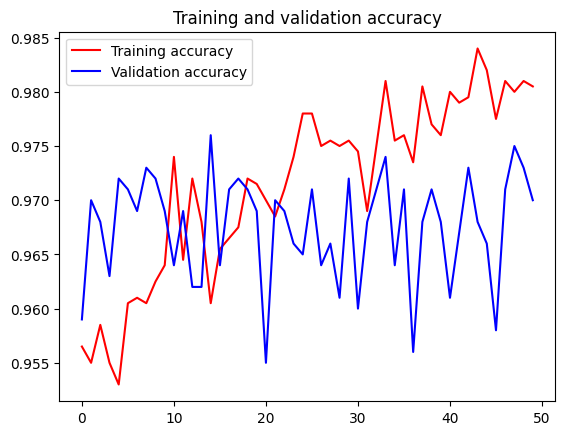

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# Adding Dropout Regularization Technique
- The idea behind it is to remove a random number of neurons in your neural network. This works very well for two reasons: The first is that neighboring neurons often end up with similar weights, which can lead to overfitting, so dropping some out at random can remove this. The second is that often a neuron can over-weigh the input from a neuron in the previous layer, and can over specialize as a result. Thus, dropping out can break the neural network out of this potential bad habit!

In [22]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer from Inception Model's midex_7 layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)  # Model(input, output)

# Print the model summary. See your dense network connected at the end.
model.summary()

# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0]

# Train the Model with Dropout

In [23]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 25,
            validation_steps = 50,
            verbose = 2)

Epoch 1/25
100/100 - 23s - loss: 0.3222 - accuracy: 0.8665 - val_loss: 0.1054 - val_accuracy: 0.9580 - 23s/epoch - 225ms/step
Epoch 2/25
100/100 - 16s - loss: 0.2232 - accuracy: 0.9070 - val_loss: 0.0950 - val_accuracy: 0.9630 - 16s/epoch - 164ms/step
Epoch 3/25
100/100 - 17s - loss: 0.1987 - accuracy: 0.9255 - val_loss: 0.0972 - val_accuracy: 0.9600 - 17s/epoch - 173ms/step
Epoch 4/25
100/100 - 16s - loss: 0.1767 - accuracy: 0.9310 - val_loss: 0.0858 - val_accuracy: 0.9690 - 16s/epoch - 164ms/step
Epoch 5/25
100/100 - 17s - loss: 0.1487 - accuracy: 0.9445 - val_loss: 0.1220 - val_accuracy: 0.9510 - 17s/epoch - 170ms/step
Epoch 6/25
100/100 - 16s - loss: 0.1564 - accuracy: 0.9465 - val_loss: 0.0875 - val_accuracy: 0.9660 - 16s/epoch - 162ms/step
Epoch 7/25
100/100 - 16s - loss: 0.1610 - accuracy: 0.9410 - val_loss: 0.0818 - val_accuracy: 0.9690 - 16s/epoch - 165ms/step
Epoch 8/25
100/100 - 22s - loss: 0.1407 - accuracy: 0.9400 - val_loss: 0.0756 - val_accuracy: 0.9670 - 22s/epoch - 219

# Evaluate the Results with Dropout

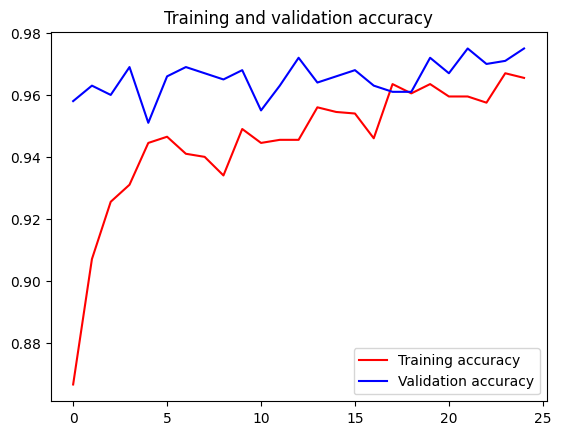

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()